In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import io
train_data = pd.read_csv("/content/train_data.csv")
test_data = pd.read_csv("/content/test_data_hidden.csv")

In [ ]:
len(train_data.columns[train_data.isnull().sum(axis = 0)> 0])

0

In [ ]:
len(test_data.columns[test_data.isnull().sum(axis = 0)> 0])

0

0.0
reject null hypothesis


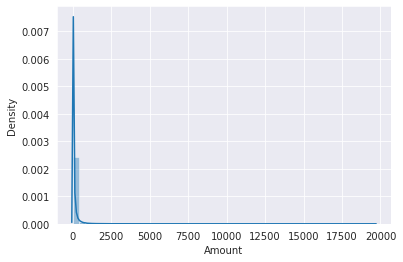

<Figure size 432x288 with 0 Axes>

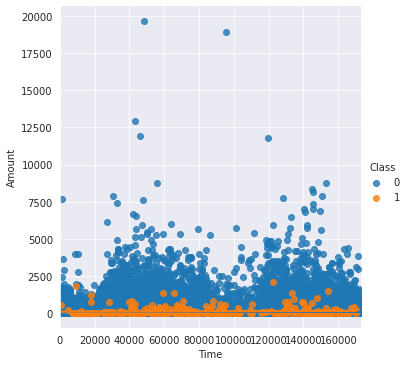

In [ ]:
from scipy import stats
ttest,pval = stats.ttest_rel(train_data['Time'],train_data['Amount'])
sns.distplot(train_data.Amount)
plt.figure()
print(pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")
    

sns.lmplot(x='Time', y = 'Amount', data = train_data, hue = 'Class')


0    227451
1       394
Name: Class, dtype: int64

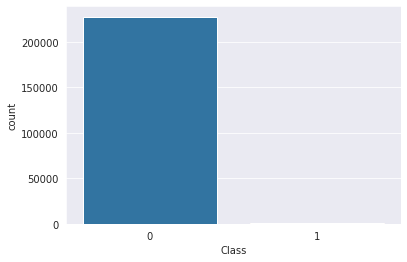

In [ ]:
Class = train_data['Class'].value_counts()
sns.countplot(x='Class', data=train_data)
Class

Random over-sampling:
1    227451
0    227451
Name: Class, dtype: int64


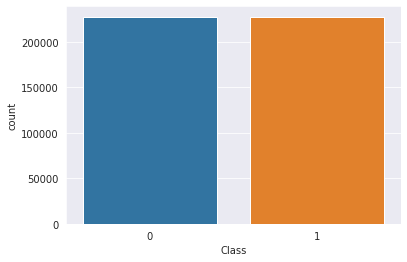

In [ ]:
count_class_0, count_class_1 = train_data['Class'].value_counts()
df_0 = train_data[train_data['Class'] == 0]
df_1 = train_data[train_data['Class'] == 1]
df_1_over = df_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_0, df_1_over], axis=0)
print('Random over-sampling:')
print(df_test_over['Class'].value_counts())

sns.set_style('darkgrid')
sns.countplot(x='Class', data=df_test_over)

In [ ]:
#ml algorithms
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

#nerual networks api
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras import optimizers
import tensorflow as tf
import time


In [ ]:
X_train = train_data.drop(['Class'], axis=1)
y_train = train_data['Class']
X_test = test_data.drop(['Class'], axis=1)
y_test = test_data['Class']

In [ ]:
from sklearn.base import BaseEstimator
class NaivePredictor(BaseEstimator):
    """ Naive predictor is a benchmark 
        model that will always predict that a loan
        will always get repaid.
    """
    
    def fit(self,X,y):
        """Do nothing"""
        pass
    
    def predict(self,X):
        """ Always predict 0 for loan repayment."""
        return np.zeros(X.shape[0])
    
    def predict_proba(self,X): 
        """ Return probability 100% for loan repayment."""
        prob = np.zeros((X.shape[0],2))
        
        #predict 100% loan repayment
        prob[:,0]=1
        
        return prob

In [ ]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
#     value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    value, update_op = tf.metrics.auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

class NeuralNetwork(BaseEstimator):
    """ Two layer neural network.
    """
    def __init__(self,input_shape=None,epochs=15,batch_size=250, optimizer='adagrad', init='normal'):
        
        self.optimizer = optimizer
        self.init = init
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape=input_shape
        
        self.model_ = Sequential()
        self.model_.add(Dense(300, input_dim=input_shape ,kernel_initializer=self.init ,  activation='relu'))
        self.model_.add(Dense(1,kernel_initializer=self.init ,activation='sigmoid'))
        self.model_.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=[ auc_roc])
    
    def fit(self,X,y,valid_set=None):
        """Fit model"""
        
        if valid_set is None:
            return self.model_.fit(X,y, epochs=self.epochs,verbose=0,  validation_split=0.1, batch_size =self.batch_size)
        else:
            return self.model_.fit(X,y, epochs=self.epochs,verbose=0,  validation_data=valid_set , batch_size =self.batch_size)
    
    def predict(self,X, y=None):
        """ Always predict 0 for loan repayment."""
        probs = np.zeros((X.shape[0],2) )
        probs[:,1] = self.model_.predict(X).flatten()
        probs[:,0] = 1 - probs[:,1]
        
        return np.argmax(probs, axis=1)
    
    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 
    
    def predict_proba(self,X): 
        """ Return probability ."""
        probs = np.zeros((X.shape[0],2) )
        probs[:,1] = self.model_.predict(X).flatten()
        probs[:,0] = 1 - probs[:,1]
        
        return probs

In [ ]:
def evaluate_models(models,X_,y_,fold_split=5):
    """ Evaluates the performance of given models."""
    results = []
    names = []
    scoring = 'roc_auc'
    for count, (name, model) in enumerate(models):
        start = time.time()
        kfold = KFold(n_splits=fold_split, random_state=54)
        cv_results = cross_val_score(model, X_, y_, cv=kfold, scoring=scoring)
        end = time.time()
        results.append(cv_results)
        names.append(name)
        time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
        msg = " {}) Model: {} Mean: {:.4f} Std: {:.4f} Elapsed Time: {}"
        print(msg.format(count+1 ,name, cv_results.mean(), cv_results.std(),time_elapsed))
        
    #return dataframe of results
    names_rows = []
    results_rows = []
    for n,arr in zip(names,results):
        for a in arr:
            names_rows.append(n)
            results_rows.append(a)
    return pd.DataFrame({'Model':names_rows,'Score':results_rows})

 1) Model: Naive Predcitor Mean: 0.5000 Std: 0.0000 Elapsed Time: 00:00:00
 2) Model: Logistic Regression Mean: 0.9458 Std: 0.0071 Elapsed Time: 00:01:05
 3) Model: NB Mean: 0.9690 Std: 0.0039 Elapsed Time: 00:00:00
 4) Model: XGB Mean: 0.9846 Std: 0.0041 Elapsed Time: 00:03:37
 5) Model: Random forest Mean: 0.9473 Std: 0.0121 Elapsed Time: 00:14:42
 6) Model: Neural Network Mean: nan Std: nan Elapsed Time: 00:00:01


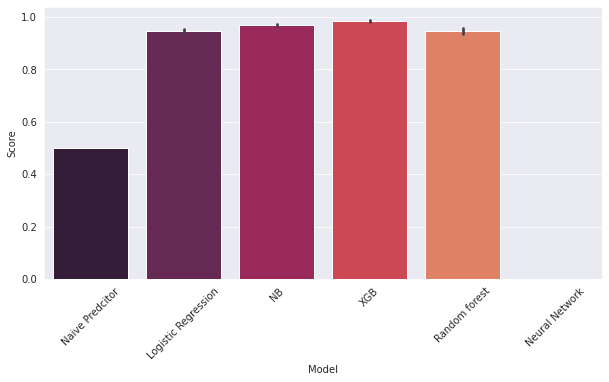

In [ ]:
#let evaluate all the models 
seed = 54
models = []

models.append(('Naive Predcitor', NaivePredictor() ))
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs',max_iter=500 )))
models.append(('NB', GaussianNB()))

# # different implentations of gradiant boosting
models.append(('XGB', xgb.XGBClassifier(random_state = seed)))
models.append(('Random forest',RandomForestClassifier(random_state=seed)))

# #neural network
models.append(('Neural Network', NeuralNetwork(input_shape=X.shape[1],init='truncated_normal') ) )

results_df = evaluate_models(models,X,y,5)

f,ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Model", y="Score", palette="rocket",data=results_df, ci="sd")

#rotate x axis
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.show()

In [ ]:
data1= train_data.sample(frac = 0.2,random_state=1)

data1.shape

(45569, 31)

In [ ]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [ ]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.002067069818581638
Fraud Cases : 94
Valid Cases : 45475


In [ ]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(45569, 30)
(45569,)


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
   
}

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
   
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 127
Accuracy Score :
0.9972130176216287
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45475
           1       0.33      0.33      0.33        94

    accuracy                           1.00     45569
   macro avg       0.66      0.66      0.66     45569
weighted avg       1.00      1.00      1.00     45569

Local Outlier Factor: 185
Accuracy Score :
0.9959402225196954
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45475
           1       0.02      0.02      0.02        94

    accuracy                           1.00     45569
   macro avg       0.51      0.51      0.51     45569
weighted avg       1.00      1.00      1.00     45569

